In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file


In [2]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [3]:
!unzip brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset-folder/


Streaming output truncated to the last 5000 lines.
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0712.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0713.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0714.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0715.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0716.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0717.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0718.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0719.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0720.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0721.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0722.jpg  
  inflating: brain-tumor-mri-dataset-folder/Training/glioma/Tr-gl_0723.jpg  
  inflating: brain-tumor-

# 1. Import needed libraries

In [4]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# 2. Preprocessing

## 2.1 Load data

In [5]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [6]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [7]:
tr_df = train_df('/content/brain-tumor-mri-dataset-folder/Training')

In [8]:
tr_df

,Class Path,Class
0,/content/brain-tumor-mri-dataset-folder/Traini...,meningioma
1,/content/brain-tumor-mri-dataset-folder/Traini...,meningioma
2,/content/brain-tumor-mri-dataset-folder/Traini...,meningioma
3,/content/brain-tumor-mri-dataset-folder/Traini...,meningioma
4,/content/brain-tumor-mri-dataset-folder/Traini...,meningioma
...,...,...
5707,/content/brain-tumor-mri-dataset-folder/Traini...,glioma
5708,/content/brain-tumor-mri-dataset-folder/Traini...,glioma
5709,/content/brain-tumor-mri-dataset-folder/Traini...,glioma
5710,/content/brain-tumor-mri-dataset-folder/Traini...,glioma


In [9]:
ts_df = test_df('/content/brain-tumor-mri-dataset-folder/Testing')

In [10]:
ts_df

,Class Path,Class
0,/content/brain-tumor-mri-dataset-folder/Testin...,meningioma
1,/content/brain-tumor-mri-dataset-folder/Testin...,meningioma
2,/content/brain-tumor-mri-dataset-folder/Testin...,meningioma
3,/content/brain-tumor-mri-dataset-folder/Testin...,meningioma
4,/content/brain-tumor-mri-dataset-folder/Testin...,meningioma
...,...,...
1306,/content/brain-tumor-mri-dataset-folder/Testin...,glioma
1307,/content/brain-tumor-mri-dataset-folder/Testin...,glioma
1308,/content/brain-tumor-mri-dataset-folder/Testin...,glioma
1309,/content/brain-tumor-mri-dataset-folder/Testin...,glioma


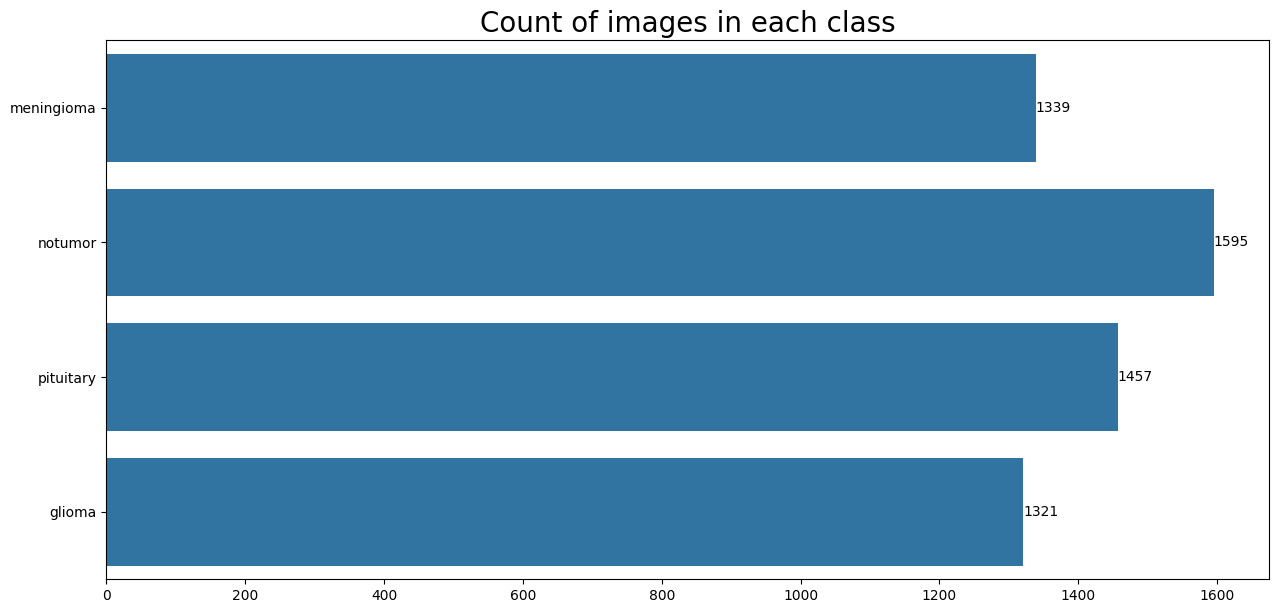

In [11]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

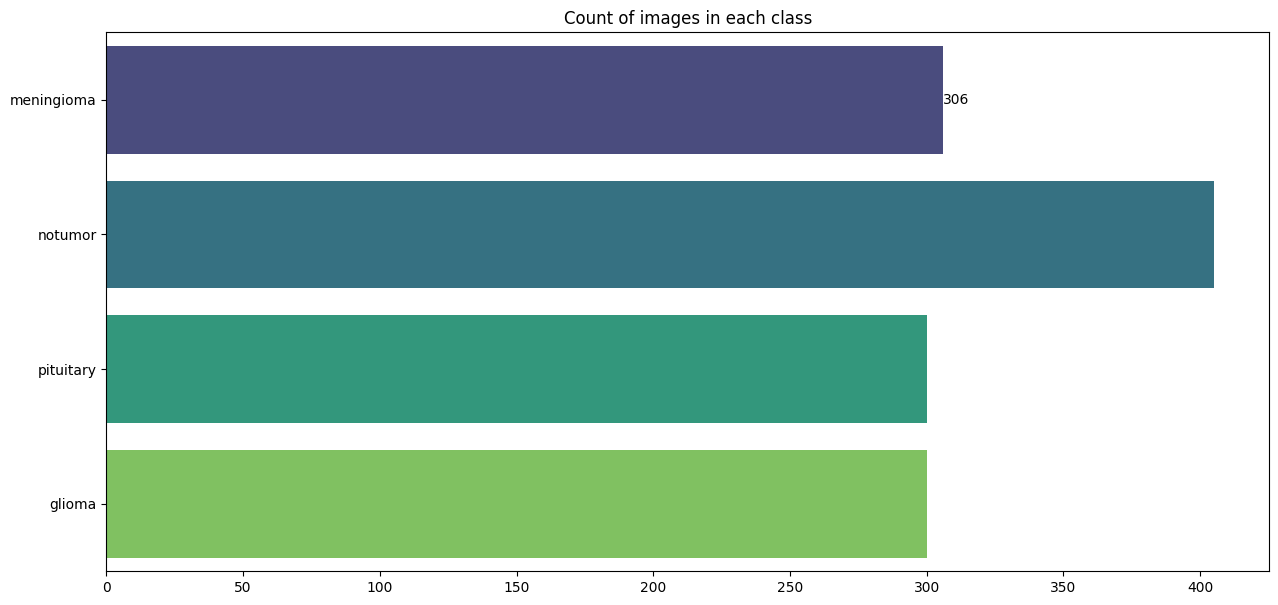

In [12]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [13]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [14]:
valid_df

,Class Path,Class
1297,/content/brain-tumor-mri-dataset-folder/Testin...,glioma
18,/content/brain-tumor-mri-dataset-folder/Testin...,meningioma
772,/content/brain-tumor-mri-dataset-folder/Testin...,pituitary
73,/content/brain-tumor-mri-dataset-folder/Testin...,meningioma
1120,/content/brain-tumor-mri-dataset-folder/Testin...,glioma
...,...,...
1070,/content/brain-tumor-mri-dataset-folder/Testin...,glioma
560,/content/brain-tumor-mri-dataset-folder/Testin...,notumor
1284,/content/brain-tumor-mri-dataset-folder/Testin...,glioma
194,/content/brain-tumor-mri-dataset-folder/Testin...,meningioma


## 2.3 Data preprocessing

In [15]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

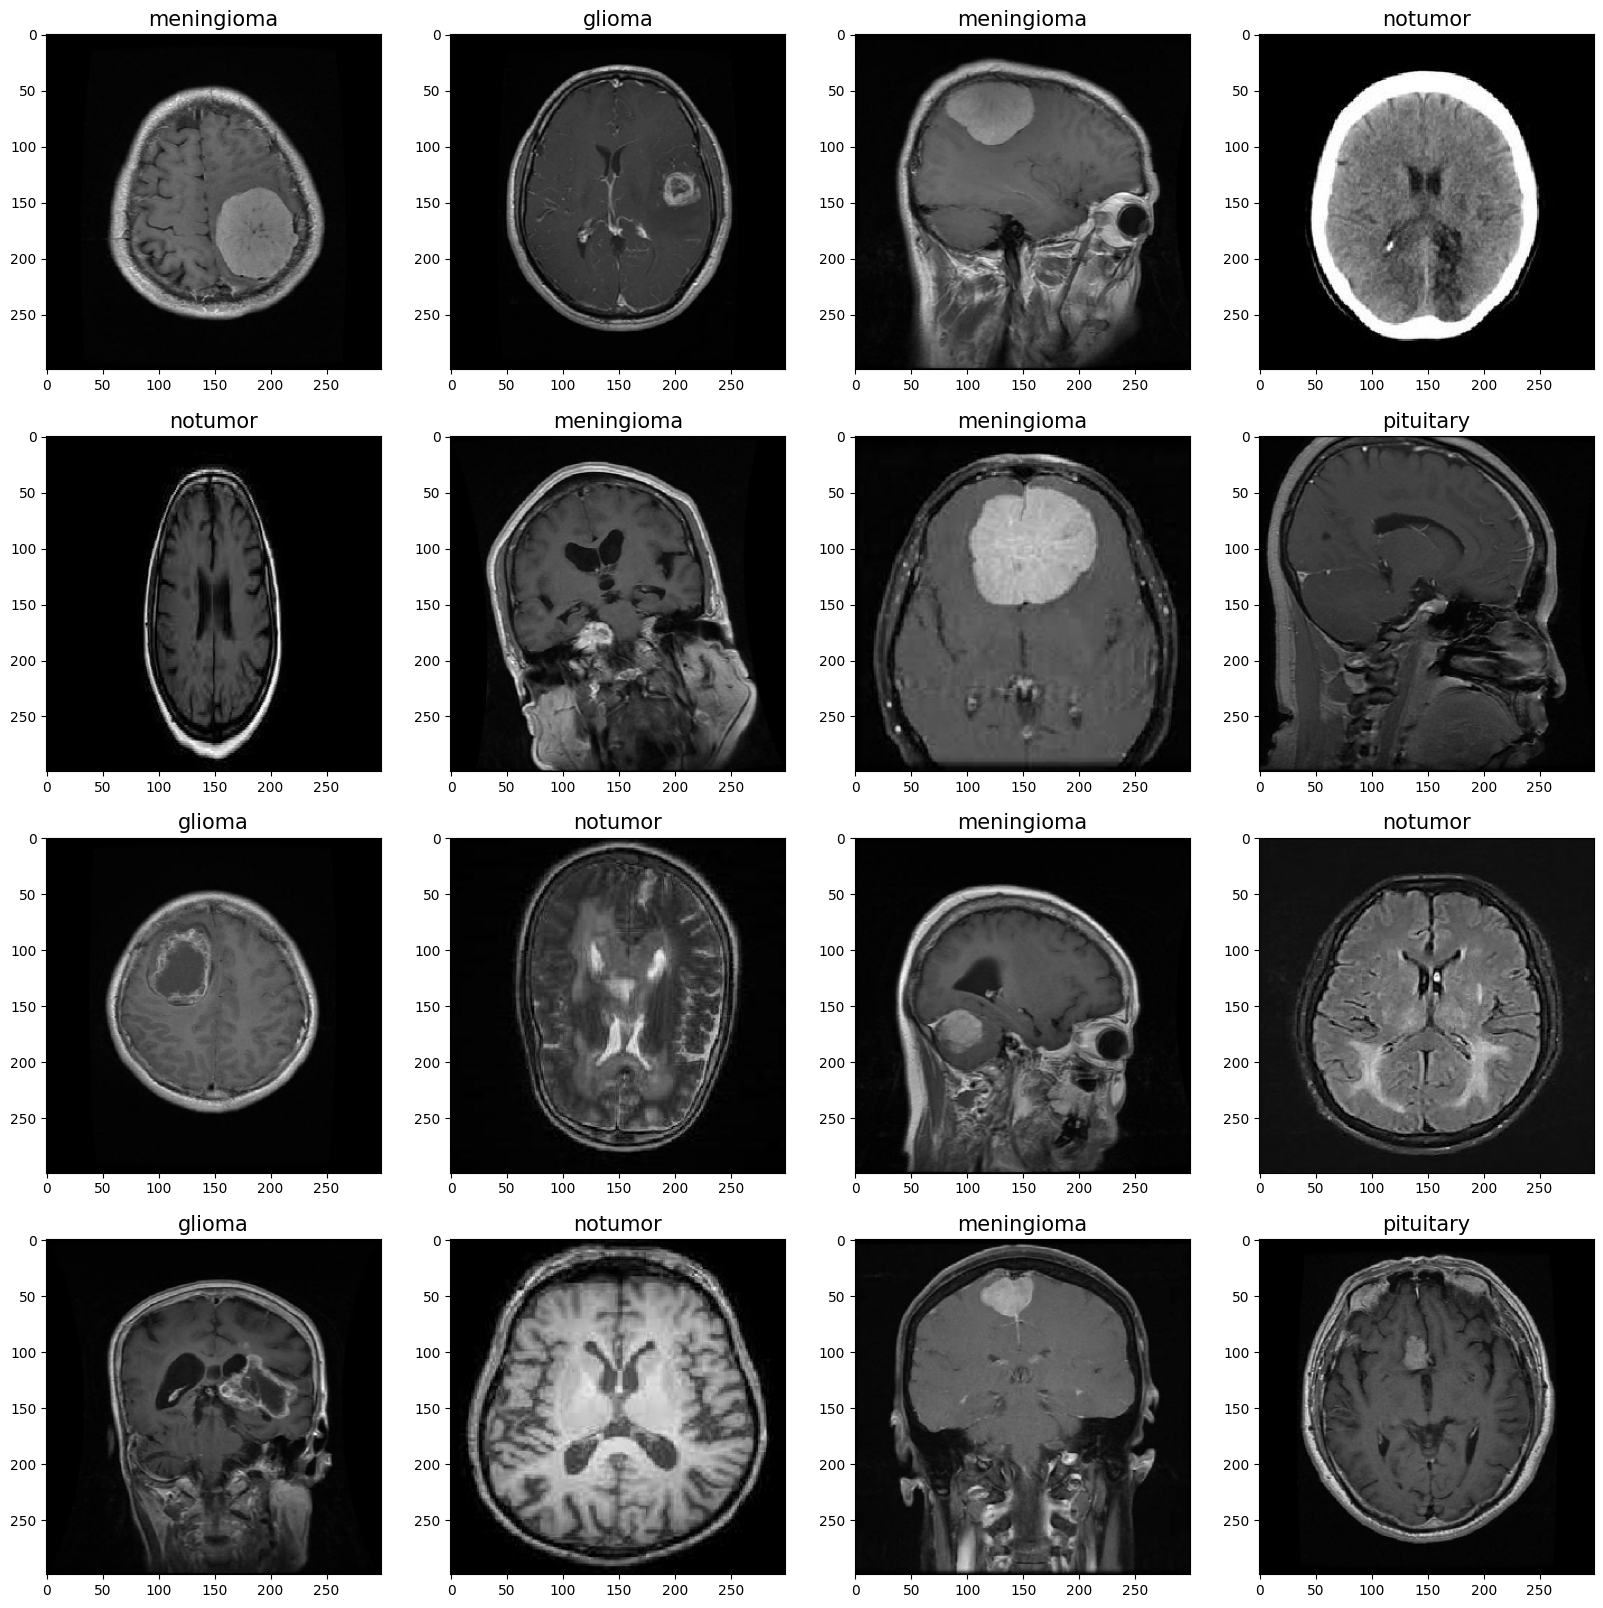

In [16]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [17]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

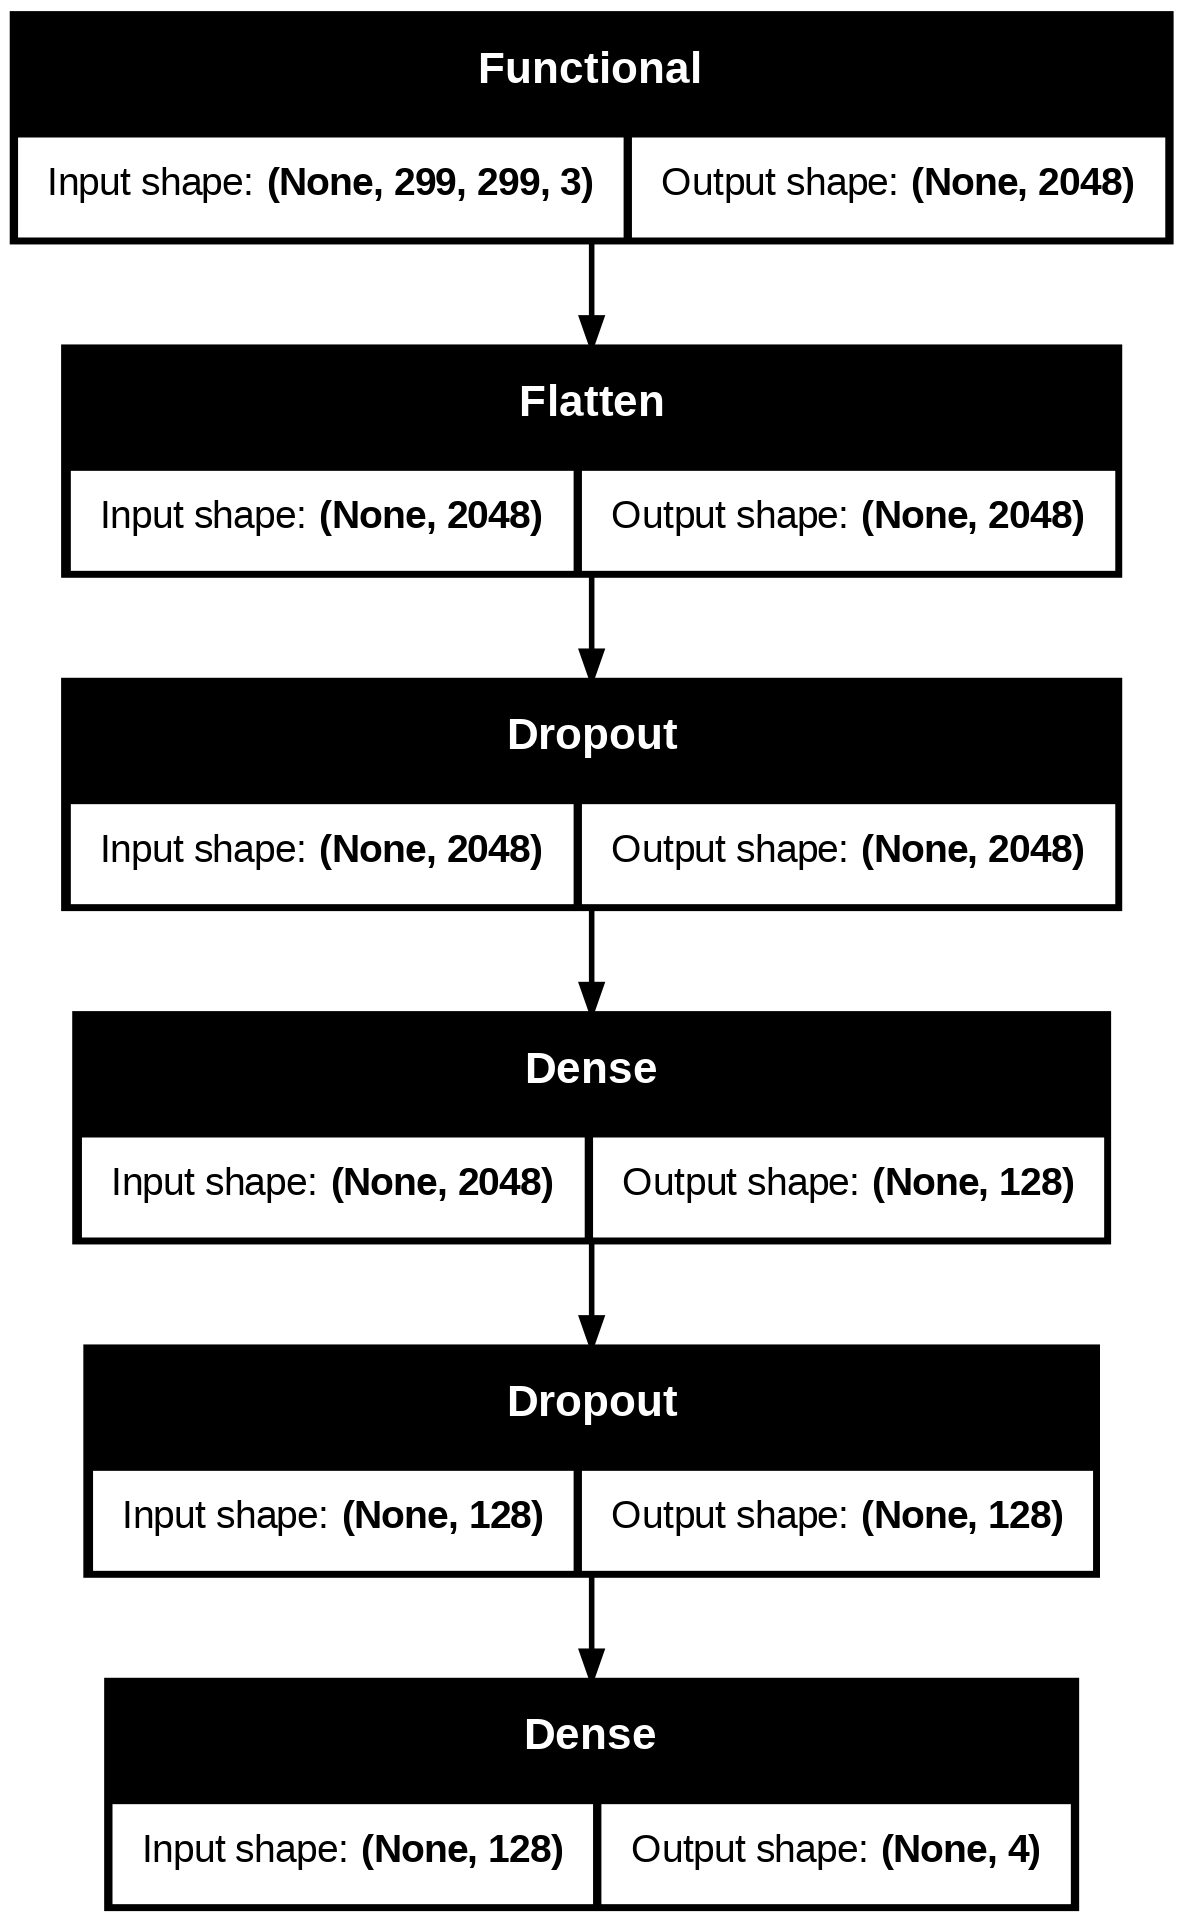

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [19]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7244 - loss: 0.7413 - precision: 0.7975 - recall: 0.6187 - val_accuracy: 0.9359 - val_loss: 0.1496 - val_precision: 0.9401 - val_recall: 0.9344
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 878ms/step - accuracy: 0.9757 - loss: 0.0827 - precision: 0.9786 - recall: 0.9730 - val_accuracy: 0.9221 - val_loss: 0.2592 - val_precision: 0.9247 - val_recall: 0.9191
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 872ms/step - accuracy: 0.9924 - loss: 0.0319 - precision: 0.9927 - recall: 0.9916 - val_accuracy: 0.9802 - val_loss: 0.0619 - val_precision: 0.9816 - val_recall: 0.9786
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 874ms/step - accuracy: 0.9954 - loss: 0.0174 - precision: 0.9955 - recall: 0.9954 - val_accuracy: 0.9832 - val_loss: 0.0509 - val_precision: 0.9847 - val_recall: 0.9832
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 874ms/step - accuracy: 0.9919 - loss: 0.0272 - precision: 0.9924 - recall: 0.9910 - val_accuracy: 0.98

In [20]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

In [28]:
model.save('brain_tumor.h5')

## 4.1 Visualize model performance

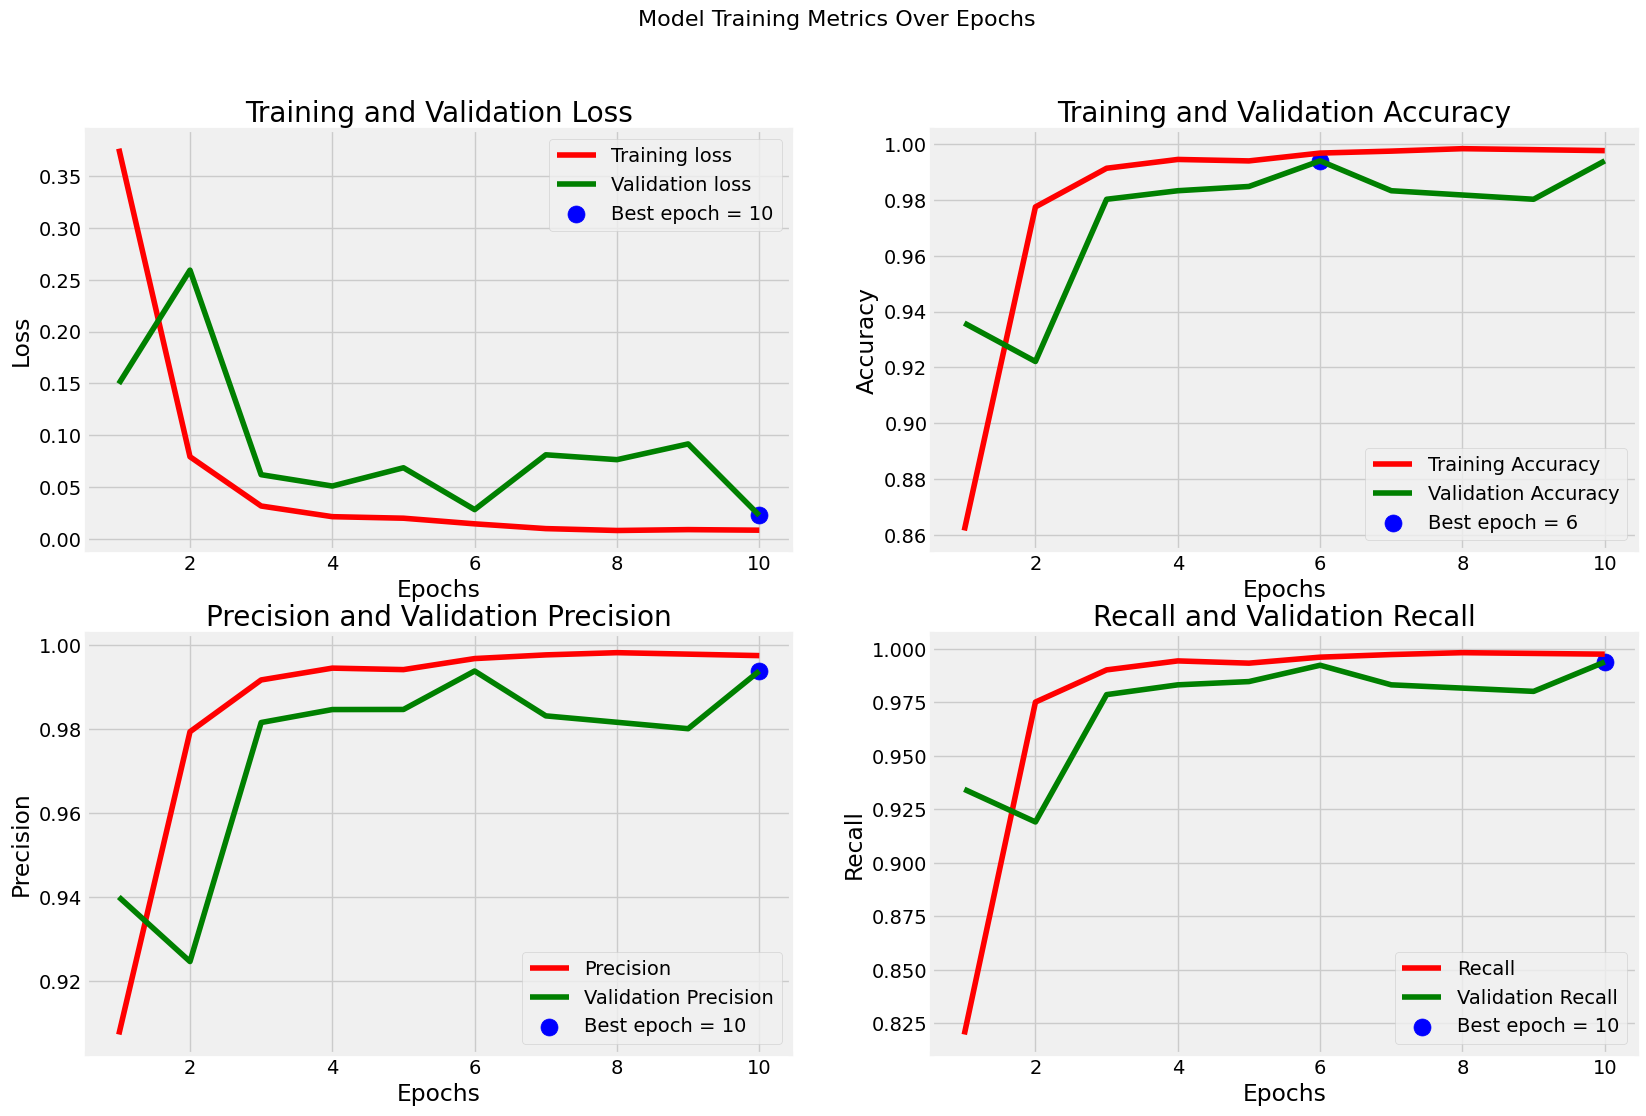

In [21]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [22]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 265ms/step - accuracy: 1.0000 - loss: 1.0874e-04 - precision: 1.0000 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.9920 - loss: 0.0280 - precision: 0.9920 - recall: 0.9920
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9953 - loss: 0.0255 - precision: 0.9953 - recall: 0.9953
Train Loss: 0.0001
Train Accuracy: 100.00%
--------------------
Validation Loss: 0.0221
Validation Accuracy: 99.39%
--------------------
Test Loss: 0.0289
Test Accuracy: 99.39%


In [23]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step


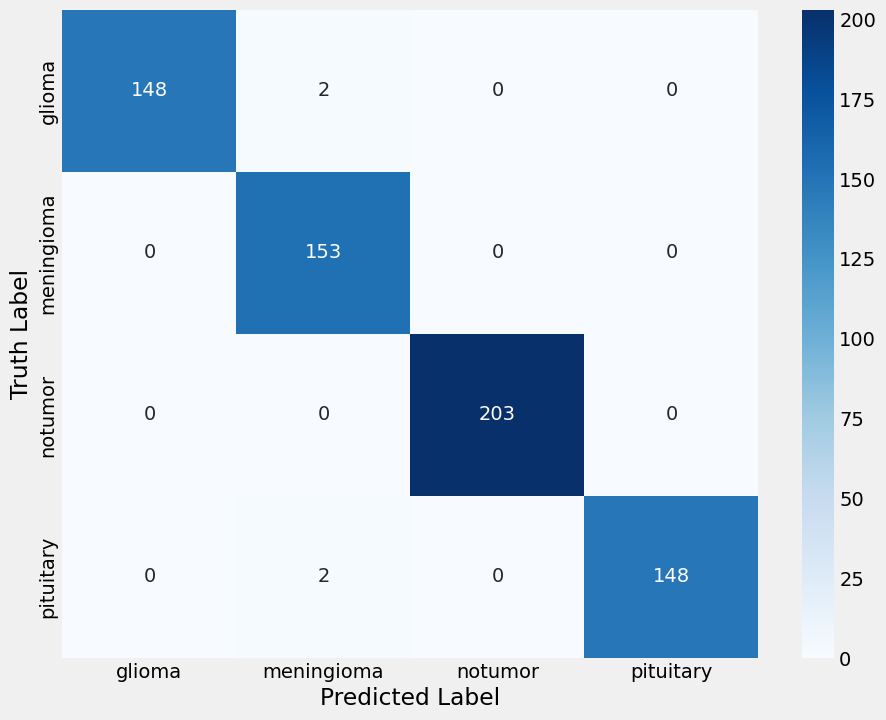

In [24]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [25]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       150
           1       0.97      1.00      0.99       153
           2       1.00      1.00      1.00       203
           3       1.00      0.99      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



## 5.2 Testing

In [27]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg')